In [2]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import itertools

## Input of PIV results, red beads masks and aggregate images

In [7]:
# # open .h5 file containing piv results.
# h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/test_piv/piv_single_aggregate1_downwards_cut1"
# with h5py.File(h5_file_path, "r") as h5f:
#     U = h5f["U"][:] # shape: frame, rows, columns 
#     V = h5f["V"][:]
#     M = h5f["M"][:]
#     xgrid = h5f["xgrid"][:]
#     ygrid = h5f["ygrid"][:]

In [3]:
h5_file_path = "F:/PhD_Franziska/Headon/RedBeads/piv_cut1/frame_1_to_375"
with h5py.File(h5_file_path+"/U_matrix", "r") as h5f:
    U = h5f["matrix"][:] # shape: frame, rows, columns 

with h5py.File(h5_file_path+"/V_matrix", "r") as h5f:
    V = h5f["matrix"][:]

with h5py.File(h5_file_path+"/M_matrix", "r") as h5f:
    M = h5f["matrix"][:]

with h5py.File(h5_file_path+"/xgrid_matrix", "r") as h5f:
    xgrid = h5f["matrix"][:]

with h5py.File(h5_file_path+"/ygrid_matrix", "r") as h5f:
    ygrid = h5f["matrix"][:]

In [3]:
# # open .h5 file of cutted masked red beads images.
# red_beads_file_path = "F:/PhD_Franziska/Headon/RedBeads/mask_red_beads_cut1.h5"
# with h5py.File(red_beads_file_path, "r") as h5f:
#     masked_red_beads = h5f["masked_red_beads"][:]

In [4]:
# open .h5 file for aggregate images and original red beads images
aggregate_file_path = "F:/PhD_Franziska/Headon/RedBeads/subregion_cut1.h5"
with h5py.File(aggregate_file_path, "r") as h5f:
    aggregate = h5f["green"][:]
    red_beads = h5f["red"][:]

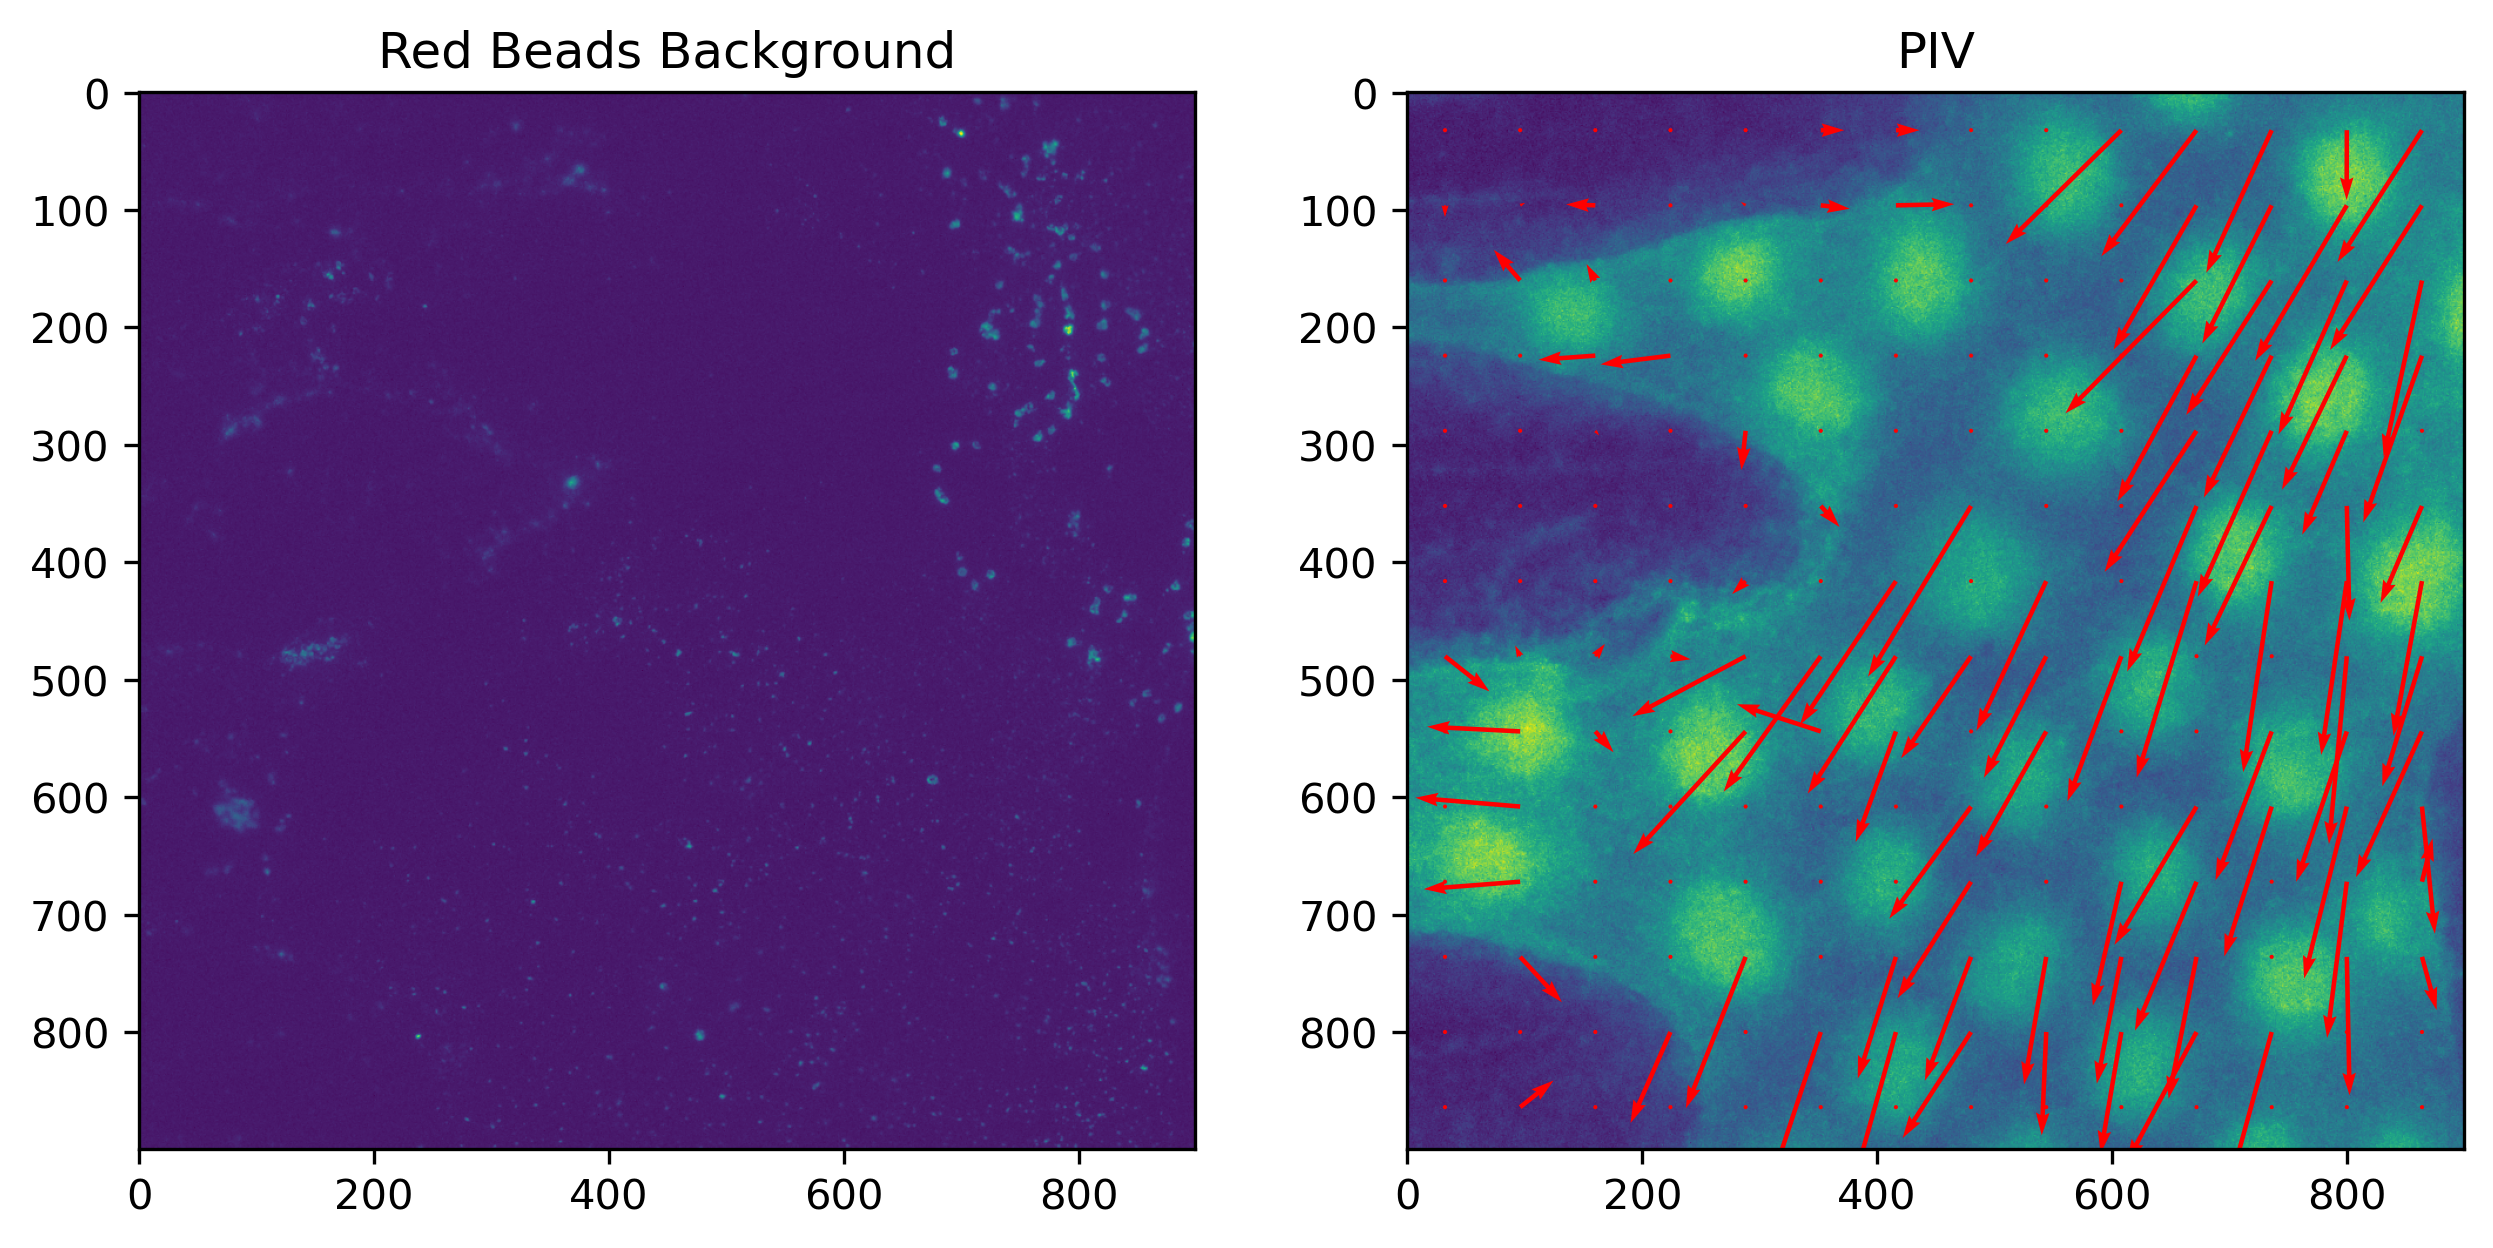

In [5]:
t = 150

plt.figure(figsize=(10, 5), dpi=300)

plt.subplot(1, 2, 1)
plt.title("Red Beads Background")
plt.imshow(red_beads[t])

plt.subplot(1, 2, 2)
plt.title("PIV")
plt.imshow(aggregate[t])
plt.quiver(ygrid[t], xgrid[t], U[t], -V[t], color = "red", scale=90)
# plt.quiver([690], [450], [-16], [-80], color="white") # center in x, y
plt.show()

## Extract one single aggregate and average the direction arrows surrounding it

In [6]:
# t = 10 

# # Determine the center of the aggregate
# # center = [450, 690] # downstream aggregate.
# center = [150, 550]

def select_neighbour_region(center, t, dist, xgrid, ygrid, U, V):
    ## Function select the vectors in the surrondings of given center [x0, y0]. 
    
    # Find out the arrows in the surrounding of the center of aggregate
    # Define the region of surrounding and found the coordinates inside the surrounding area.
    neighbour_region = [[i for i in range(center[0]-dist, center[0]+dist)],
                       [i for i in range(center[1]-dist, center[1]+dist)]]
    neighbour_xgrid = np.unique(xgrid[0][np.isin(xgrid[0], neighbour_region[0])])
    neighbour_ygrid = np.unique(ygrid[0][np.isin(ygrid[0], neighbour_region[1])])
    # The grid of considered vectors. 
    grid_combi = [list(comb) for comb in itertools.product(neighbour_xgrid, neighbour_ygrid)]
    final_select_xgrid = [comb[0] for comb in grid_combi]
    final_select_ygrid = [comb[1] for comb in grid_combi]
    
    # Determine the indices of the grids in order to find the corresponding U and V elements.
    row_indices = [np.where(xgrid[0][:, 0] == number)[0][0] for number in final_select_xgrid]
    col_indices = [np.where(ygrid[0][0, :] == number)[0][0] for number in final_select_ygrid]
    vec_indeces = [[x, y] for x, y in zip(row_indices, col_indices)]
    # Pick out the vector directions from U and V based on the vec_indices list. 
    select_U = [U[t][row, col] for row, col in vec_indeces]
    select_V = [V[t][row, col] for row, col in vec_indeces]

    return np.array(final_select_xgrid), np.array(final_select_ygrid), np.array(select_U), np.array(select_V)

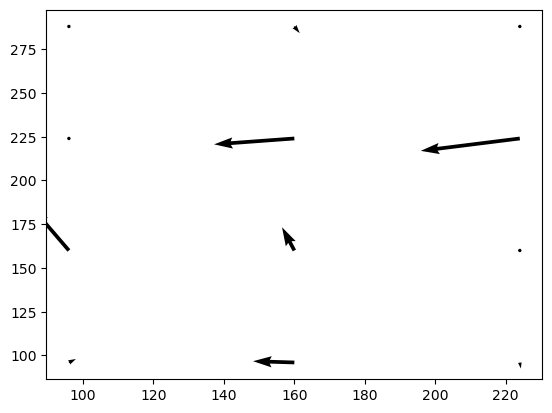

In [14]:
#center = [200, 170] # [y, x]
x, y, u, v = select_neighbour_region([190, 170], 150, 100, xgrid, ygrid, U, V)
plt.quiver(y, x, u, -v)

In [8]:
#center = [200, 170] # [y, x]

def avrage_neighbour_direction_over_time(center, t0, t1, dist, xgrid, ygrid, U, V):
    # Calculate the average of vectors over the time t0 to t1 within the neighbour region. 

    avg_vec_u = [] 
    avg_vec_v = []

    for t in range(t0, t1): 
        x, y, u, v = select_neighbour_region(center, t, dist, xgrid, ygrid, U, V)
        avg_vec_u.append(np.mean(u))
        avg_vec_v.append(np.mean(v))

    return np.array(avg_vec_u), np.array(avg_vec_v) 

In [15]:
t0 = 0
t1 = np.shape(U)[0]

avg_u, avg_v = avrage_neighbour_direction_over_time([190, 170], t0, t1, 100, xgrid, ygrid, U, V)

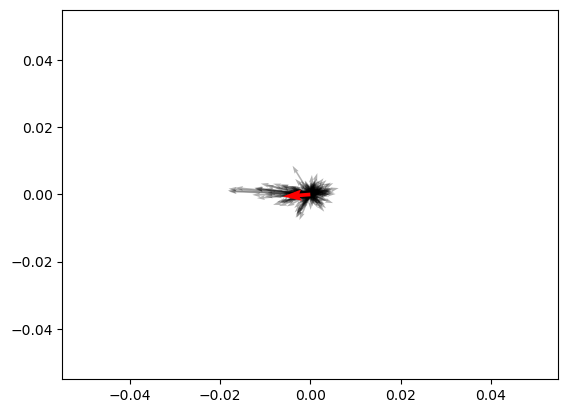

In [16]:
origin = np.zeros(t1-t0)
# x components: avg_u, y components: -avg_v
plt.quiver(origin, origin, avg_u, -avg_v, alpha = 0.3)
plt.quiver([0], [0], [-68], [-5], color="red")

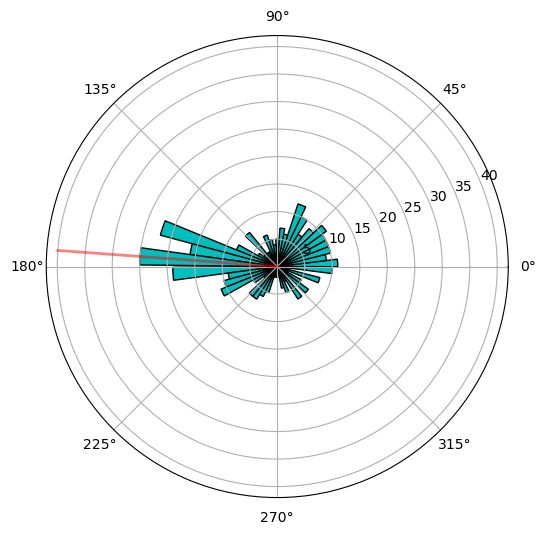

In [17]:
# Having vectors in x and y components. Convert into angles and magnitudes.
angles = np.arctan2(-avg_v, avg_u)

# Extra vecotor for highlighting. 
extra_angle = np.arctan2(5, -68) # np.arctan2(y, x)
#extra_magnitude = np.sqrt(x**2 + y**2)

# Plot in a rose plot. Histogramm counting the number of vectors with certain angle. 
plt.figure(figsize=(6, 6))
ax = plt.subplot(111, projection='polar')
num_bins = 50
ax.hist(angles, bins=num_bins, color='c', edgecolor='black') # The number of vectors with certain angle.
ax.plot([extra_angle, extra_angle], [0, 40], color='red', linewidth=2, label='Highlighted Vector', alpha=0.5)
#ax.set_title('Rose Plot from Vector Components')
#plt.savefig("subregion_cut1_direction_all_frame(h2)", dpi=300)
plt.show()

In [12]:
def dot_product_polarisation_to_avg_vectors(avg_u, avg_v, polar_u, polar_v):
    # Having multiple average vectors from neighbour regions, calculate the dot product between average vectors and polarization vectors.
    # avg_u, -avg_v: the x and y components of average flow vectors. The values are in order of frame number/time.
    # polar_u, polar_v: the x and y components of reference vector. 

    # Normalization of average flow vectors.
    magnitude_flow_vector = np.sqrt(avg_u**2 + avg_v**2)
    magnitude_flow_vector[magnitude_flow_vector==0] = 1e-10 # Prevent division by zero.
    avg_u_normalized = avg_u / magnitude_flow_vector
    avg_v_normalized = avg_v / magnitude_flow_vector

    # Normalization of reference vector. 
    magnitude_ref_vector = np.sqrt(polar_u**2 + polar_v**2) # Known the reference vector has non-zero magnitude.
    polar_u_normalized = polar_u / magnitude_ref_vector
    polar_v_normalized = polar_v / magnitude_ref_vector

    # Calculation of dot product. Apply term: dot_product = x_ref * x + y_ref * y.
    dot_products = polar_u_normalized * avg_u_normalized + polar_v_normalized * avg_v_normalized

    return dot_products

Text(0, 0.5, 'dot product')

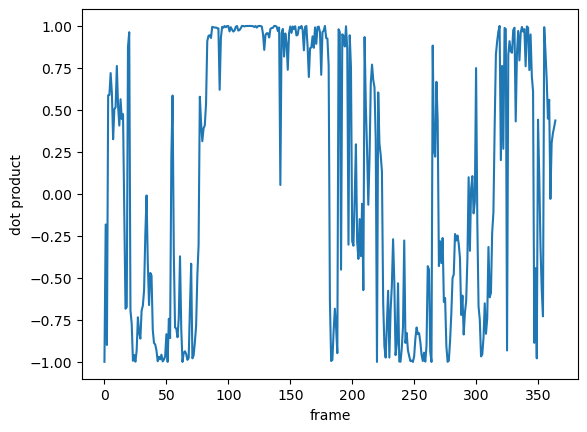

In [18]:
angle_all_frame = dot_product_polarisation_to_avg_vectors(avg_u, -avg_v, -68, 5)
plt.figure()
plt.plot(angle_all_frame)
plt.xlabel("frame")
plt.ylabel("dot product")

In [ ]:
def velocity_avg_flow(): 
    # For each 

## Cut the regions that are not covered by skin tissue. Those are NaN in red beads masks. 

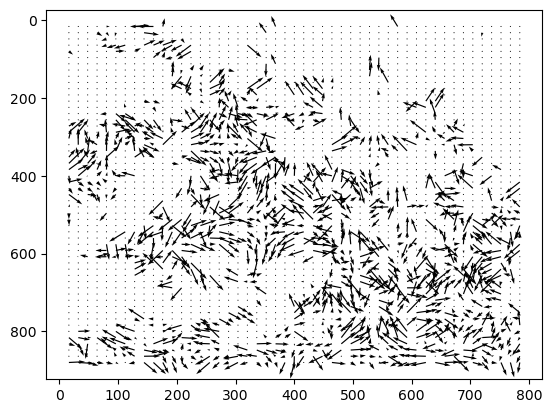

In [8]:
# Alternative 1: Use index from grid matrix, check if the correspoding position has in red beads mask value NaN.
# If the value is NaN, then find out the index of this position in grid matrices. 
# Then set the vector values with this index to NaN. 

xgrid_matrix = xgrid[0]
ygrid_matrix = ygrid[0]
red_bead_mask = sub_frame[0]
U_matrix = U[0]
V_matrix = V[0]

# Find out the index for position from grid matrix which corresponds to NaN in masks. 
for i in range(xgrid_matrix.shape[0]):
    mask_value = red_bead_mask[xgrid_matrix[i,:].astype(int), ygrid_matrix[i,:].astype(int)]
    is_nan = np.isnan(mask_value)
    col_index = np.where(is_nan)[0]
    row_index = np.full(len(col_index), i)

    # Change the vector value with those index to NaN. 
    U_matrix[row_index, col_index] = np.nan
    V_matrix[row_index, col_index] = np.nan

# Plot the cutted vector field.
plt.quiver(ygrid_matrix, xgrid_matrix, U_matrix, V_matrix)
plt.gca().invert_yaxis()

In [8]:
# Write the above processing as function.
def piv_mask(t, xgrid_set, ygrid_set, red_bead_set, U, V): 
    
    xgrid_matrix = xgrid[t]
    ygrid_matrix = ygrid[t]
    red_bead_mask = red_bead_set[t]
    U_matrix = U[t]
    V_matrix = V[t]
    
    # Find out the index for position from grid matrix which corresponds to NaN in masks. 
    for i in range(xgrid_matrix.shape[0]):
        mask_value = red_bead_mask[xgrid_matrix[i,:].astype(int), ygrid_matrix[i,:].astype(int)]
        is_nan = np.isnan(mask_value)
        col_index = np.where(is_nan)[0]
        row_index = np.full(len(col_index), i)
    
        # Change the vector value with those index to NaN. 
        U_matrix[row_index, col_index] = np.nan
        V_matrix[row_index, col_index] = np.nan
        
    return ygrid_matrix, xgrid_matrix, U_matrix, V_matrix

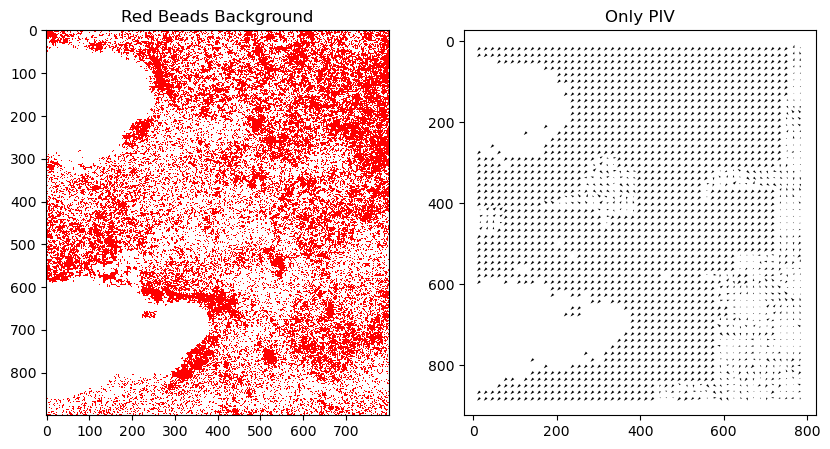

In [10]:
ygrid_matrix, xgrid_matrix, U_matrix, V_matrix = piv_mask(0, xgrid, ygrid, sub_frame, U, V)

t = 0

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Red Beads Background")
plt.imshow(sub_frame[t], cmap= ListedColormap(["white", "red"]))

plt.subplot(1, 2, 2)
plt.title("Only PIV")
plt.quiver(ygrid_matrix, xgrid_matrix, U_matrix, V_matrix)
plt.gca().invert_yaxis()
plt.show()

In [83]:
# Alternative 2: Get all index of NaN in mask. Find if the index appears in grid matrix.
# If appears, find out the position in grid matrices.
# Set the vector values with those positions to NaN. 

# xgrid_matrix = xgrid[0]
# ygrid_matrix = ygrid[0]
# red_bead_mask = sub_frame[0]
# U_matrix = U[0]
# V_matrix = V[0]

# # Find out the positions of NaN in red bead mask 
